<a href="https://colab.research.google.com/github/m-pedram/kaggleCovid/blob/main/kaggleCovid/Report02/Kaggle_Covid_Basic_Pipeline_report02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ارایه‌ی یک روش بهبود یافته برای پیش‌بینی ضرورت بستری‌شدن بیماران کووید ۱۹
# در بخش مراقبت‌های ویژه با استفاده از تکنیک‌های ترکیبی داده‌کاوی
**گزارش شماره ۲**
---


دانشجو:	مهنام پدرام

دانشکده:	مکانیک، برق و کامپیوتر

گروه تخصصی:	مهندسی نرم‌افزار

استاد راهنما:	خانم دکتر مریم رستگارپور     


In [ ]:
# imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, \
    balanced_accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, NuSVC
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA

# Reading and preprocessing the Data

Cleaning the data has been carried out manually. The already cleaned table has been uploaded in a Github Repository.

In [ ]:
# read data from Google Drive
# from google.colab import drive 
# drive.mount('/content/drive')

data = pd.read_csv('https://raw.githubusercontent.com/m-pedram/kaggleCovid/main/Report02/rawData.csv')

To fill the missing values the next or the previous entries have been copied. In this regard, the Forward filling (Padding) has been favored over backfilling.

In [ ]:
filledData = data.query("PATIENT_VISIT_IDENTIFIER == 0").fillna(method='pad')
filledData = filledData.query("PATIENT_VISIT_IDENTIFIER == 0").fillna(method='backfill')
for patient_identifier in range(1,255):
  tempDf = data.query("PATIENT_VISIT_IDENTIFIER == @patient_identifier").fillna(method='pad')
  tempDf2 = tempDf.query("PATIENT_VISIT_IDENTIFIER == @patient_identifier").fillna(method='backfill')
  filledData = pd.concat([filledData, tempDf2])

In [ ]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(filledData)
table = imp.transform(filledData)

Remove time series information and reshape all information of each single patient into a single vector.

In [ ]:
clean_table = np.concatenate((table[0,0:85], table[1,1:85], table[2,1:85], table[3,1:86]))
for patient in range(1, 251):
  row_number = int(patient * 4)
  clean_table = np.vstack((clean_table, np.concatenate((table[row_number,0:85], table[row_number+1,1:85], table[row_number+2,1:85], table[row_number+3,1:86]))))

# Classifiers

In [ ]:
#functions

def random_imputation(df, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace=True)
    return df

def knn_imputation(X):
  imputer = KNNImputer(n_neighbors=2, weights="uniform")
  return imputer.fit_transform(X)


def logistic_regression(X_tr, X_ts, y_tr, cWeight):
    clf = LogisticRegression(random_state=0, max_iter= 1000, class_weight=cWeight).fit(X_tr, y_tr.reshape(-1, ))
    return clf.predict(X_ts)


def support_vector_machine(X_tr, X_ts, y_tr,cWeight):
    # default kernel is 'RBF'
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf', class_weight=cWeight))
    clf.fit(X_tr, y_tr.reshape(-1, ))
    return clf.predict(X_ts)


def metrics_report(y_true, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  balancedAccuracy = balanced_accuracy_score(y_test, y_pred)
  precision = average_precision_score(y_test, y_pred)
  return accuracy, f1, balancedAccuracy, precision

# Train and Prediction

In [ ]:
# define input-output sets
inputs = clean_table[:,1:-1]
outputs = clean_table[:,-1]
print(inputs.shape)
print(outputs.shape)

(251, 336)
(251,)


In [ ]:
#split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=.3, shuffle=False)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(175, 336)
(76, 336)
(175,)
(76,)


In [ ]:
#PCA
pca = PCA(.8)
pca.fit(X_train)
train_low_dim = pca.transform(X_train)
test_low_dim = pca.transform(X_test)
train_low_dim.shape

(175, 17)

In [ ]:
# train a logistic_regression classifier
# without and without balancing weights with and without PCA
print (' ---- Logistic regression experiments ----')
y_predicted = logistic_regression(X_train, X_test, y_train, 'None')
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('No balancing weights, no PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)

# 
y_predicted = logistic_regression(train_low_dim, test_low_dim, y_train, 'None')
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('No balancing weights, with PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)

#
y_predicted = logistic_regression(X_train, X_test, y_train, 'balanced')
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)
print('')
print('Weighted, no PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)

#
y_predicted = logistic_regression(train_low_dim, test_low_dim, y_train, 'balanced')
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('Weighted, with PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)

 ---- Logistic regression experiments ----

No balancing weights, no PCA
accuracy: 0.7105263157894737
f1_score: 0.08333333333333333
balanced accuracy: 0.47291666666666665
average precision: 0.20518092105263158

No balancing weights, with PCA
accuracy: 0.7368421052631579
f1_score: 0.16666666666666666
balanced accuracy: 0.5125
average precision: 0.21546052631578946

Weighted, no PCA
accuracy: 0.6973684210526315
f1_score: 0.34285714285714286
balanced accuracy: 0.5791666666666666
average precision: 0.25

Weighted, with PCA
accuracy: 0.7105263157894737
f1_score: 0.38888888888888884
balanced accuracy: 0.6104166666666666
average precision: 0.27154605263157894


In [ ]:
# train a linear support vector machine (SVM) classifier
print (' ---- SVM with RBF kernel experiments ----')
y_predicted = support_vector_machine(X_train, X_test, y_train,None)
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('No balancing weights, no PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)

#
y_predicted = support_vector_machine(train_low_dim, test_low_dim, y_train, None)
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('No balancing weights, with PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)

#

y_predicted = support_vector_machine(X_train, X_test, y_train,'balanced')
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('Weighted, no PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)


#
y_predicted = support_vector_machine(train_low_dim, test_low_dim, y_train, 'balanced')
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('weighted, with PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)

 ---- SVM with RBF kernel experiments ----

No balancing weights, no PCA
accuracy: 0.7763157894736842
f1_score: 0.0
balanced accuracy: 0.49166666666666664
average precision: 0.21052631578947367

No balancing weights, with PCA
accuracy: 0.7763157894736842
f1_score: 0.0
balanced accuracy: 0.49166666666666664
average precision: 0.21052631578947367

Weighted, no PCA
accuracy: 0.6842105263157895
f1_score: 0.4
balanced accuracy: 0.6166666666666667
average precision: 0.27192982456140347

weighted, with PCA
accuracy: 0.6710526315789473
f1_score: 0.24242424242424243
balanced accuracy: 0.5166666666666666
average precision: 0.21671826625386997


In [ ]:
# train a non linear support_vector_machine classifier

print (' ---- Nonlinear SVM experiments ----')
clf = NuSVC(gamma="auto", nu=0.1, class_weight=None)
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('No balancing weights, no PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)

#
clf = NuSVC(gamma="auto", nu=0.1, class_weight=None)
clf.fit(train_low_dim, y_train)
y_predicted = clf.predict(test_low_dim)
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('No balancing weights, with PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)

#

clf = NuSVC(gamma="auto", nu=0.1, class_weight='balanced')
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('weighted, no PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)


#
clf = NuSVC(gamma="auto", nu=0.1, class_weight='balanced')
clf.fit(train_low_dim, y_train)
y_predicted = clf.predict(test_low_dim)
acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('weighted, with PCA')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)

 ---- Nonlinear SVM experiments ----

No balancing weights, no PCA
accuracy: 0.6578947368421053
f1_score: 0.13333333333333333
balanced accuracy: 0.4625
average precision: 0.2020676691729323

No balancing weights, with PCA
accuracy: 0.618421052631579
f1_score: 0.2564102564102564
balanced accuracy: 0.50625
average precision: 0.2126716247139588

weighted, no PCA
accuracy: 0.6578947368421053
f1_score: 0.13333333333333333
balanced accuracy: 0.4625
average precision: 0.2020676691729323

weighted, with PCA
accuracy: 0.618421052631579
f1_score: 0.2564102564102564
balanced accuracy: 0.50625
average precision: 0.2126716247139588


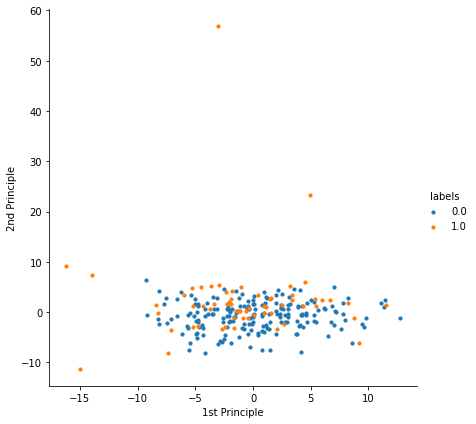

In [ ]:
# PCA and t_SNE cluster visualization

# standardize the data
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
import seaborn as sns
import matplotlib.pyplot as plt

inputs = clean_table[:,1:-1]
outputs = clean_table[:,-1]

# inputs = np.vstack((inputs, inputs))
# outputs = np.hstack((outputs, outputs))

standardized_data = StandardScaler().fit_transform(inputs)
sample_data = standardized_data

# PCA
cov_matrix = np.matmul(sample_data.T, sample_data)
values, vectors = eigh(cov_matrix, eigvals=(334, 335))
new_cord = np.matmul(vectors.T, sample_data.T)
new_cord = np.vstack((new_cord, outputs)).T

dataframe = pd.DataFrame(data=new_cord, columns=("1st Principle", 
                                                 "2nd Principle", "labels"))
sns.FacetGrid(dataframe, hue="labels", height=6).map(plt.scatter, "1st Principle", 
                                                 "2nd Principle", s=10).add_legend()
plt.show()

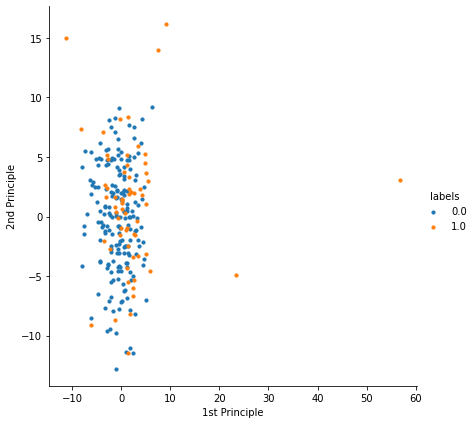

In [ ]:
# PCA with sklearn
from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(sample_data)
pca_data = np.vstack((pca_data.T, outputs)).T
pca_df = pd.DataFrame(pca_data, columns=("1st Principle", 
                                                 "2nd Principle", "labels"))
sns.FacetGrid(pca_df, hue="labels", height=6).map(plt.scatter, "1st Principle", 
                                                 "2nd Principle", s=10).add_legend()
plt.show()

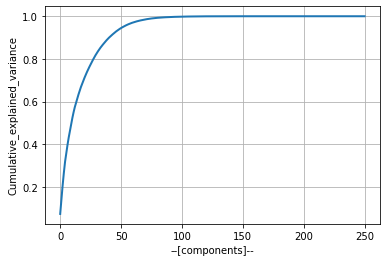

In [ ]:
from IPython.core.pylabtools import figsize
# find most influential components
pca.n_components = 251
pca_data = pca.fit_transform(sample_data)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel("--[components]--")
plt.ylabel('Cumulative_explained_variance')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


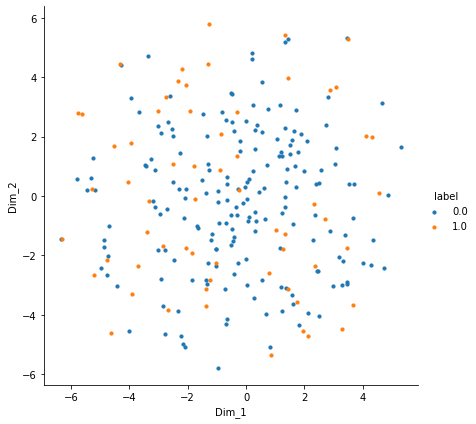

In [ ]:
#t_SNE
from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity=50, 
             learning_rate='auto', n_iter=500, n_iter_without_progress=300, 
             min_grad_norm=1e-07, metric='euclidean',
             init='pca', verbose=0, random_state=None, method='barnes_hut', 
             n_jobs=None, square_distances=True)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(sample_data)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, outputs)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2', s=10).add_legend()
plt.show()

In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 27.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=bed4a92b844c494083429fffeb83134a0a02a851573054bb845508f544046bb7
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=38dfdcc1fa868aeb5ad32bd6d8841669c2a30bf9d7b4de04b5416f5281bced39
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


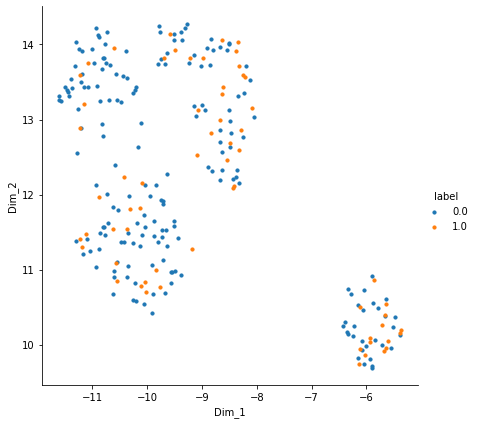

In [ ]:
#UMAP: unsupervised 
import umap
# standardized_data = StandardScaler().fit_transform(inputs)
# sample_data = standardized_data

reducer = umap.UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=2, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='random', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.001, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=1, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )

embedding = reducer.fit_transform(inputs)
embedding_data = np.vstack((embedding.T, outputs)).T
embedding_df = pd.DataFrame(data=embedding_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(embedding_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2', s=10).add_legend()
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


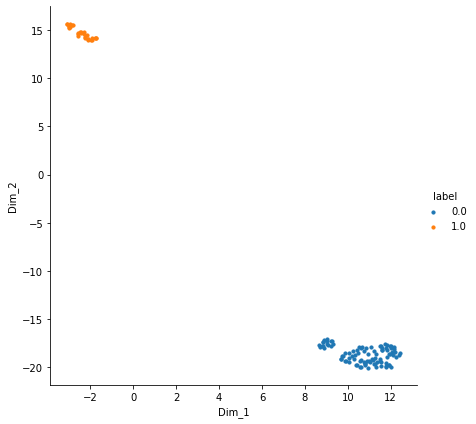

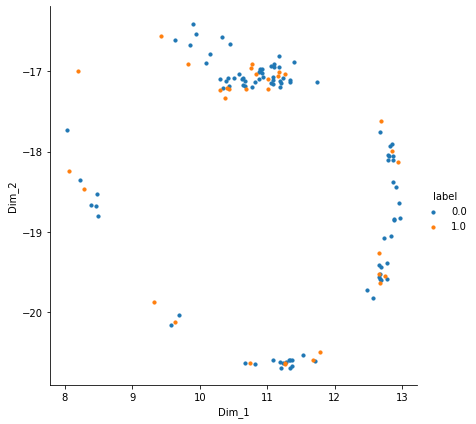

In [ ]:
#UMAP: supervised 
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=.5, shuffle=False)

reducer = umap.UMAP(n_neighbors=50, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=2, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.001, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=1, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )

embedding = reducer.fit_transform(X_train, y_train)
X_test_res = reducer.transform(X_test)

embedding_data_train = np.vstack((embedding.T, y_train)).T
embedding_train_df = pd.DataFrame(data=embedding_data_train, columns=("Dim_1", "Dim_2", "label"))

embedding_data_test = np.vstack((X_test_res.T, y_test)).T
embedding_test_df = pd.DataFrame(data=embedding_data_test, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of umap
sns.FacetGrid(embedding_train_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2', s=10).add_legend()

# Ploting the result of umap
sns.FacetGrid(embedding_test_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2', s=10).add_legend()
plt.show()

In [ ]:
#PCA
from sklearn.decomposition import PCA
#TSNE
from sklearn.manifold import TSNE
#UMAP
import umap
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [ ]:
def plot_2d(component1, component2):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y, #set color equal to a variable
            colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict( l=100,r=100,b=100,t=100),width=2000,height=1200)                 
    fig.layout.template = 'plotly_dark'
    
    fig.show()

def plot_3d(component1,component2,component3):
  fig = go.Figure(data=[go.Scatter3d(
    x=component1,
    y=component2,
    z=component3,
    mode='markers',
    marker=dict(
        size=10,
        color=y,                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=1,
        line_width=1
    )
  )])
  # tight layout
  fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
  fig.layout.template = 'plotly_dark'

  fig.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
tps = StandardScaler().fit_transform(inputs)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
# Preprocess
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(tps.copy())

In [ ]:
manifold = umap.UMAP().fit(sample_data, outputs)
X_reduced = manifold.transform(sample_data)

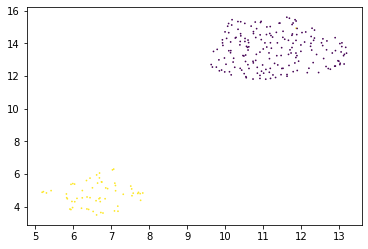

In [ ]:

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=outputs, s=0.5);

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


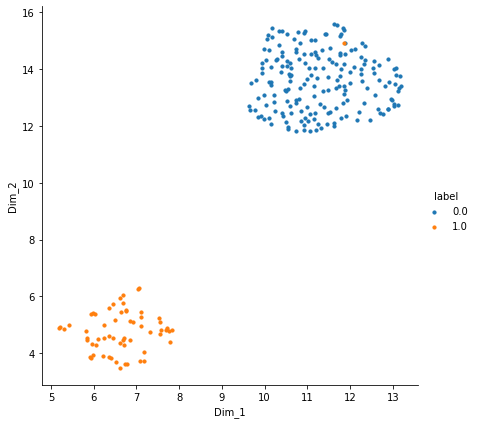

In [ ]:
embedding_data = np.vstack((X_reduced.T, outputs)).T
embedding_df = pd.DataFrame(data=embedding_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(embedding_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2', s=10).add_legend()
plt.show()

In [ ]:
# random forest as a simple example of ensemble learning 

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create and train a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_predicted=clf.predict(X_test)

acc, f_1, balancedAcc, pr = metrics_report(y_test, y_predicted)

print('')
print('---- Random Forest Experiment ----')
print ('accuracy:', acc)
print ('f1_score:', f_1)
print ('balanced accuracy:', balancedAcc)
print ('average precision:', pr)


---- Random Forest Experiment ----
accuracy: 0.7763157894736842
f1_score: 0.26086956521739124
balanced accuracy: 0.5604166666666667
average precision: 0.2514097744360902


In [ ]:
import statistics

# Random Forest Experiment: Gini criterion, no bootstrap, no weighted 
itr_num = 100
acc = []
f_1= []
balancedAcc = []
pr = []

for exp in range(itr_num):
  clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)

  clf.fit(X_train,y_train)

  y_predicted=clf.predict(X_test)

  a, f, b, p = metrics_report(y_test, y_predicted)
  acc.append(a) 
  f_1.append(f)
  balancedAcc.append(b)
  pr.append(p)

print('')
print ('accuracy:', statistics.mean(acc), 'std:', statistics.pstdev(acc))
print ('f1_score:', statistics.mean(f_1), 'std:', statistics.pstdev(f_1))
print ('balanced accuracy:', statistics.mean(balancedAcc), 'std:', statistics.pstdev(balancedAcc))
print ('average precision:', statistics.mean(pr), 'std:', statistics.pstdev(pr))


accuracy: 0.7882894736842105 std: 0.022181494495658805
f1_score: 0.2683284957859329 std: 0.10349778124534999
balanced accuracy: 0.5686875 std: 0.04072312401892949
average precision: 0.27188879751461986 std: 0.046239323978721436


In [ ]:
# Random Forest Experiment: Gini criterion, with bootstrap, no weighted 
itr_num = 100
acc = []
f_1= []
balancedAcc = []
pr = []

for exp in range(itr_num):
  clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)

  clf.fit(X_train,y_train)

  y_predicted=clf.predict(X_test)

  a, f, b, p = metrics_report(y_test, y_predicted)
  acc.append(a) 
  f_1.append(f)
  balancedAcc.append(b)
  pr.append(p)

print('')
print ('accuracy:', statistics.mean(acc), 'std:', statistics.pstdev(acc))
print ('f1_score:', statistics.mean(f_1), 'std:', statistics.pstdev(f_1))
print ('balanced accuracy:', statistics.mean(balancedAcc), 'std:', statistics.pstdev(balancedAcc))
print ('average precision:', statistics.mean(pr), 'std:', statistics.pstdev(pr))


accuracy: 0.7769736842105264 std: 0.018827747396387092
f1_score: 0.1974214911455186 std: 0.09680210117010245
balanced accuracy: 0.5415833333333333 std: 0.03481837796975105
average precision: 0.24486815998329156 std: 0.030217398159434947


In [ ]:
# Random Forest Experiment: Gini criterion, with bootstrap, with weighted 
itr_num = 100
acc = []
f_1= []
balancedAcc = []
pr = []

for exp in range(itr_num):
  clf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)

  clf.fit(X_train,y_train)

  y_predicted=clf.predict(X_test)

  a, f, b, p = metrics_report(y_test, y_predicted)
  acc.append(a) 
  f_1.append(f)
  balancedAcc.append(b)
  pr.append(p)

print('')
print ('accuracy:', statistics.mean(acc), 'std:', statistics.pstdev(acc))
print ('f1_score:', statistics.mean(f_1), 'std:', statistics.pstdev(f_1))
print ('balanced accuracy:', statistics.mean(balancedAcc), 'std:', statistics.pstdev(balancedAcc))
print ('average precision:', statistics.mean(pr), 'std:', statistics.pstdev(pr))


accuracy: 0.7855263157894737 std: 0.019293260919230507
f1_score: 0.19058078436422762 std: 0.07801908751471394
balanced accuracy: 0.5424166666666667 std: 0.027788136957262108
average precision: 0.25032265559732664 std: 0.032033940489040034


In [ ]:
# Random Forest Experiment: Gini criterion, no bootstrap, with weighted 
itr_num = 100
acc = []
f_1= []
balancedAcc = []
pr = []

for exp in range(itr_num):
  clf = RandomForestClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)

  clf.fit(X_train,y_train)

  y_predicted=clf.predict(X_test)

  a, f, b, p = metrics_report(y_test, y_predicted)
  acc.append(a) 
  f_1.append(f)
  balancedAcc.append(b)
  pr.append(p)

print('')
print ('accuracy:', statistics.mean(acc), 'std:', statistics.pstdev(acc))
print ('f1_score:', statistics.mean(f_1), 'std:', statistics.pstdev(f_1))
print ('balanced accuracy:', statistics.mean(balancedAcc), 'std:', statistics.pstdev(balancedAcc))
print ('average precision:', statistics.mean(pr), 'std:', statistics.pstdev(pr))


accuracy: 0.7822368421052631 std: 0.0182676886538353
f1_score: 0.26374441766386847 std: 0.05797204070625063
balanced accuracy: 0.5639375 std: 0.02437890816247612
average precision: 0.26141473000683524 std: 0.028727602711258828


In [ ]:
# Random Forest Experiment: Entropy criterion, no bootstrap, no weighted 
itr_num = 100
acc = []
f_1= []
balancedAcc = []
pr = []

for exp in range(itr_num):
  clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)

  clf.fit(X_train,y_train)

  y_predicted=clf.predict(X_test)

  a, f, b, p = metrics_report(y_test, y_predicted)
  acc.append(a) 
  f_1.append(f)
  balancedAcc.append(b)
  pr.append(p)

print('')
print ('accuracy:', statistics.mean(acc), 'std:', statistics.pstdev(acc))
print ('f1_score:', statistics.mean(f_1), 'std:', statistics.pstdev(f_1))
print ('balanced accuracy:', statistics.mean(balancedAcc), 'std:', statistics.pstdev(balancedAcc))
print ('average precision:', statistics.mean(pr), 'std:', statistics.pstdev(pr))



accuracy: 0.7817105263157895 std: 0.02256837870675525
f1_score: 0.22625994877230574 std: 0.08702092912185878
balanced accuracy: 0.5516875 std: 0.03387668481870025
average precision: 0.2555017622180451 std: 0.03782901415287887


In [ ]:
# Random Forest Experiment: Entropy criterion, with bootstrap, no weighted 
itr_num = 100
acc = []
f_1= []
balancedAcc = []
pr = []

for exp in range(itr_num):
  clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)

  clf.fit(X_train,y_train)

  y_predicted=clf.predict(X_test)

  a, f, b, p = metrics_report(y_test, y_predicted)
  acc.append(a) 
  f_1.append(f)
  balancedAcc.append(b)
  pr.append(p)

print('')
print ('accuracy:', statistics.mean(acc), 'std:', statistics.pstdev(acc))
print ('f1_score:', statistics.mean(f_1), 'std:', statistics.pstdev(f_1))
print ('balanced accuracy:', statistics.mean(balancedAcc), 'std:', statistics.pstdev(balancedAcc))
print ('average precision:', statistics.mean(pr), 'std:', statistics.pstdev(pr))


accuracy: 0.7828947368421053 std: 0.019560616772787517
f1_score: 0.1757954282552075 std: 0.09250845796612787
balanced accuracy: 0.5375416666666667 std: 0.033020642743929476
average precision: 0.24533217157477025 std: 0.034097122147887876


In [ ]:
# Random Forest Experiment: Entropy criterion, with bootstrap, with weighted 
itr_num = 100
acc = []
f_1= []
balancedAcc = []
pr = []

for exp in range(itr_num):
  clf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='entropy',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)

  clf.fit(X_train,y_train)

  y_predicted=clf.predict(X_test)

  a, f, b, p = metrics_report(y_test, y_predicted)
  acc.append(a) 
  f_1.append(f)
  balancedAcc.append(b)
  pr.append(p)

print('')
print ('accuracy:', statistics.mean(acc), 'std:', statistics.pstdev(acc))
print ('f1_score:', statistics.mean(f_1), 'std:', statistics.pstdev(f_1))
print ('balanced accuracy:', statistics.mean(balancedAcc), 'std:', statistics.pstdev(balancedAcc))
print ('average precision:', statistics.mean(pr), 'std:', statistics.pstdev(pr))


accuracy: 0.7785526315789474 std: 0.018798298826786526
f1_score: 0.1685737350234456 std: 0.06877054032634956
balanced accuracy: 0.5329583333333333 std: 0.024854402415758155
average precision: 0.23857131109022556 std: 0.027121701780587603


In [ ]:
# Random Forest Experiment: Entropy criterion, with bootstrap, with weighted 
itr_num = 100
acc = []
f_1= []
balancedAcc = []
pr = []

for exp in range(itr_num):
  clf = RandomForestClassifier(bootstrap=False, class_weight='balanced', criterion='entropy',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)

  clf.fit(X_train,y_train)

  y_predicted=clf.predict(X_test)

  a, f, b, p = metrics_report(y_test, y_predicted)
  acc.append(a) 
  f_1.append(f)
  balancedAcc.append(b)
  pr.append(p)

print('')
print ('accuracy:', statistics.mean(acc), 'std:', statistics.pstdev(acc))
print ('f1_score:', statistics.mean(f_1), 'std:', statistics.pstdev(f_1))
print ('balanced accuracy:', statistics.mean(balancedAcc), 'std:', statistics.pstdev(balancedAcc))
print ('average precision:', statistics.mean(pr), 'std:', statistics.pstdev(pr))


accuracy: 0.78 std: 0.025519532468211918
f1_score: 0.22394516114447463 std: 0.0815044063288019
balanced accuracy: 0.5499166666666667 std: 0.033875691874853286
average precision: 0.25415245144110277 std: 0.0370295844717702


In [ ]:
# Change number of estimators
est_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
num_itr = 100
acc = np.zeros((100, len(est_values)))
f_1= np.zeros((100, len(est_values)))
balancedAcc = np.zeros((100, len(est_values)))
pr = np.zeros((100, len(est_values)))

cnt = 0
for exp in est_values:
  for itr in range(num_itr):
    clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                max_depth=None, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=exp, n_jobs=1,
                oob_score=False, random_state=None, verbose=0,
                warm_start=False)

    clf.fit(X_train,y_train)

    y_predicted=clf.predict(X_test)

    a, f, b, p = metrics_report(y_test, y_predicted)
    acc[itr, cnt] = a
    f_1[itr, cnt] = f
    balancedAcc[itr, cnt] = b
    pr[itr, cnt] = p
  cnt += 1


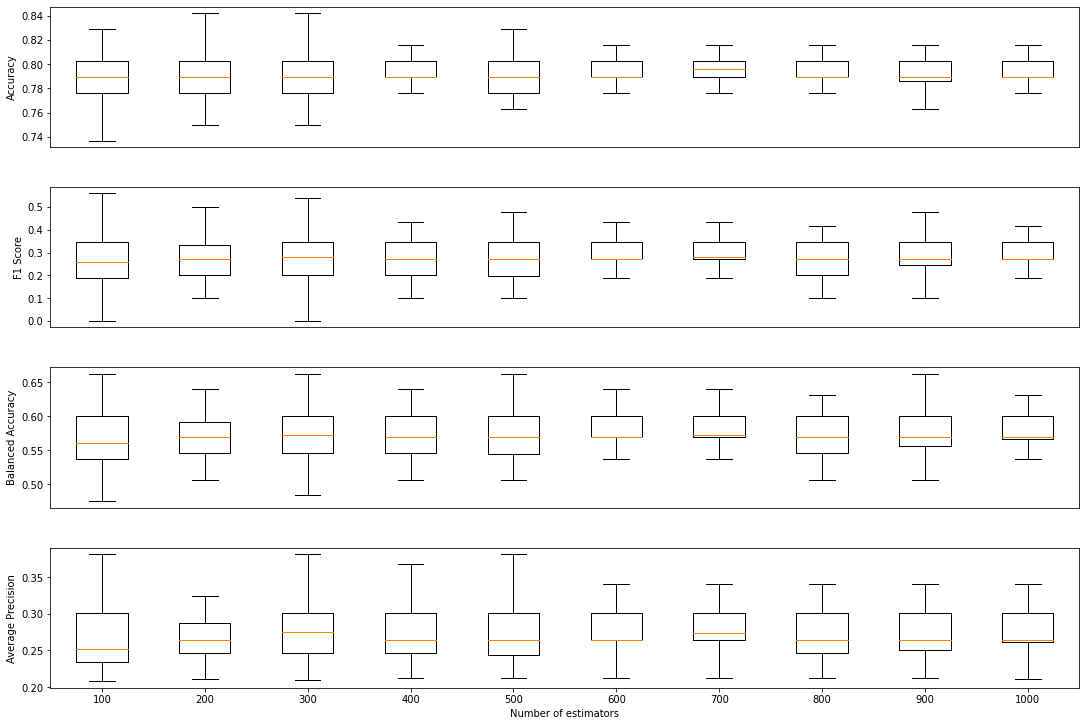

In [ ]:
plt.figure(figsize=(16,11))

plt.subplot(4,1,1)
plt.ylabel('Accuracy')
plt.boxplot(acc, showfliers=False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.subplot(4,1,2)
plt.ylabel('F1 Score')
plt.boxplot(f_1, showfliers=False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.subplot(4,1,3)
plt.ylabel('Balanced Accuracy')
plt.boxplot(balancedAcc,showfliers=False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.subplot(4,1,4)
plt.ylabel('Average Precision')
plt.boxplot(pr,labels=est_values, showfliers=False)
plt.xlabel('Number of estimators')


plt.tight_layout(4)
plt.show()

In [ ]:
# finding the most important features 
clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf.fit(X_train,y_train)
y_predicted=clf.predict(X_test)
idx = np.arange(X_train.shape[1])
feature_imp = pd.Series(clf.feature_importances_, index=idx).sort_values(ascending=False)
print(feature_imp[:10])
print(feature_imp.index[:10])


317    0.036533
287    0.028211
203    0.015676
214    0.015532
119    0.015162
298    0.015023
305    0.014692
35     0.014276
190    0.012351
60     0.010600
dtype: float64
Int64Index([317, 287, 203, 214, 119, 298, 305, 35, 190, 60], dtype='int64')


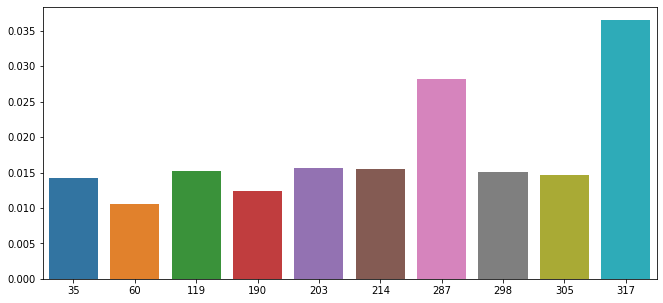

In [ ]:
# Add labels to your graph
plt.figure(figsize=(11,5))
sns.barplot(y=feature_imp[:10], x=feature_imp.index[:10])
plt.show()

In [ ]:
# pick n most important features
n = 10
X = np.vstack((inputs[:,feature_imp.index[0]], inputs[:,feature_imp.index[1]]))
for f in range(n-2):
  X = np.vstack((X, inputs[:, feature_imp.index[f+2]]))
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X.T, outputs, test_size=.3, shuffle=False)

(10, 251)


In [ ]:
itr_num = 100
acc = []
f_1= []
balancedAcc = []
pr = []

for exp in range(itr_num):
  clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)

  clf.fit(X_train,y_train)

  y_predicted=clf.predict(X_test)

  a, f, b, p = metrics_report(y_test, y_predicted)
  acc.append(a) 
  f_1.append(f)
  balancedAcc.append(b)
  pr.append(p)

print('')
print('---- Random forest trained on 10 most important features ----')
print ('accuracy:', statistics.mean(acc), 'std:', statistics.pstdev(acc))
print ('f1_score:', statistics.mean(f_1), 'std:', statistics.pstdev(f_1))
print ('balanced accuracy:', statistics.mean(balancedAcc), 'std:', statistics.pstdev(balancedAcc))
print ('average precision:', statistics.mean(pr), 'std:', statistics.pstdev(pr))


---- Random forest trained on 10 most important features ----
accuracy: 0.7463157894736842 std: 0.013934949784077619
f1_score: 0.45066415632592105 std: 0.03742222057787035
balanced accuracy: 0.6543958333333333 std: 0.026211769448835173
average precision: 0.31254743629908105 std: 0.02396438785874023


In [ ]:
# pick n most important features
num = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
acc = np.zeros((100, len(num)))
f_1= np.zeros((100, len(num)))
balancedAcc = np.zeros((100, len(num)))
pr = np.zeros((100, len(num)))

cnt = 0
for n in num:
  print(n)
  X = np.vstack((inputs[:,feature_imp.index[0]], inputs[:,feature_imp.index[1]]))
  for f in range(n-2):
    X = np.vstack((X, inputs[:, feature_imp.index[f+2]]))
  X_train, X_test, y_train, y_test = train_test_split(X.T, outputs, test_size=.3, shuffle=False)
  for itr in range(itr_num):
    clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                max_depth=None, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
                oob_score=False, random_state=None, verbose=0,
                warm_start=False)

    clf.fit(X_train,y_train)

    y_predicted=clf.predict(X_test)

    a, f, b, p = metrics_report(y_test, y_predicted)
    acc[itr, cnt] = a
    f_1[itr, cnt] = f
    balancedAcc[itr, cnt] = b
    pr[itr, cnt] = p
  cnt += 1


5
10
15
20
25
30
35
40
45
50
55
60
65
70
75


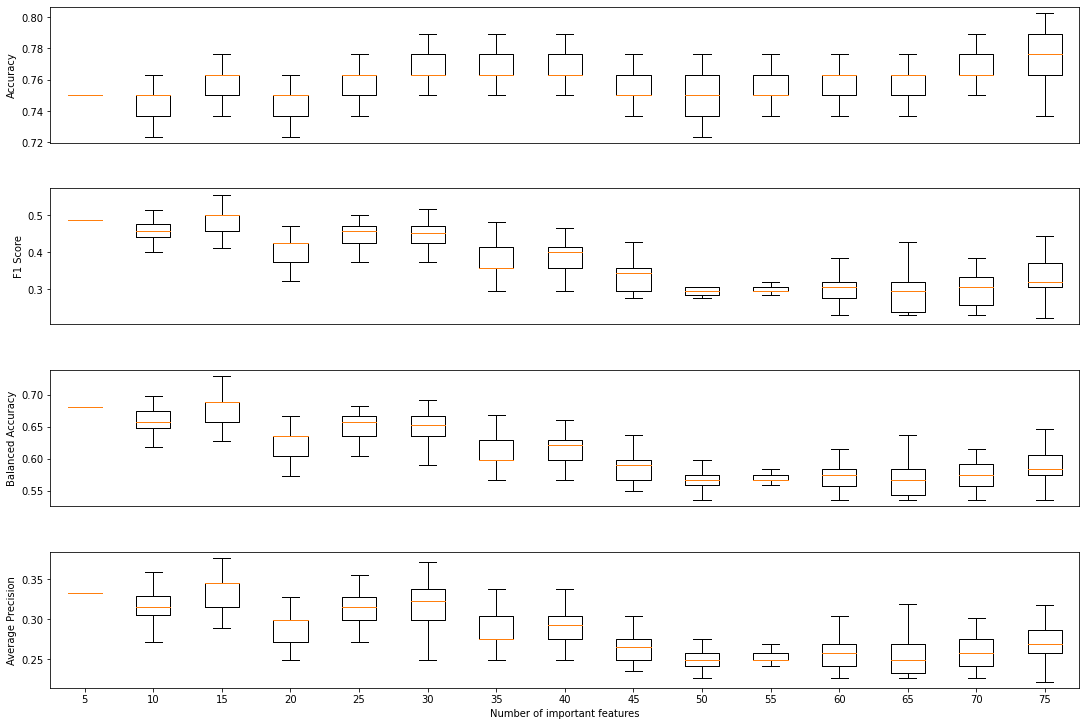

In [ ]:
plt.figure(figsize=(16,11))
plt.subplot(4,1,1)
plt.ylabel('Accuracy')
plt.boxplot(acc, showfliers=False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)



plt.subplot(4,1,2)
plt.ylabel('F1 Score')
plt.boxplot(f_1, showfliers=False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.subplot(4,1,3)
plt.ylabel('Balanced Accuracy')
plt.boxplot(balancedAcc, showfliers=False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.subplot(4,1,4)
plt.ylabel('Average Precision')
plt.boxplot(pr, labels=num, showfliers=False)
plt.xlabel('Number of important features')

plt.tight_layout(4)
plt.show()